In [1]:
!pip install transformers

In [2]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
df = pd.read_csv("amazon_alexa.tsv",sep="\t")

In [4]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
df.rating.value_counts()

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64

In [6]:
possible_labels = df.rating.unique()

In [7]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [8]:
df['label'] = df.rating.replace(label_dict)

In [9]:
df.head()

,rating,date,variation,verified_reviews,feedback,label
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,0
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,0
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,0
4,5,31-Jul-18,Charcoal Fabric,Music,1,0


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [12]:
df['data_type'] = ['not_set']*df.shape[0]

In [13]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [14]:
df.groupby(['rating', 'label', 'data_type']).count()

date  variation  verified_reviews  feedback
rating label data_type                                             
1      4     train       137        137               137       137
             val          24         24                24        24
2      3     train        81         81                81        81
             val          15         15                15        15
3      2     train       129        129               129       129
             val          23         23                23        23
4      1     train       387        387               387       387
             val          68         68                68        68
5      0     train      1943       1943              1943      1943
             val         343        343               343       343

## Loading Tokenizer and Encoding our Data

In [15]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [17]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].verified_reviews.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].verified_reviews.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [18]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [19]:
len(dataset_train)

2677

In [20]:
len(dataset_val)

473

In [21]:
from transformers import BertForSequenceClassification

In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [24]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [25]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [26]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [27]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [28]:
import numpy as np

In [29]:
from sklearn.metrics import f1_score

In [30]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [31]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [32]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [34]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [35]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), 'reviews_bert.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 1.0196846400698025
Validation loss: 0.7605816503365834
F1 Score (Weighted): 0.6284664753850799



Epoch 2
Training loss: 0.7113641216641381
Validation loss: 0.6731373111406962
F1 Score (Weighted): 0.6963626251301437



Epoch 3
Training loss: 0.6383417365806443
Validation loss: 0.6589842875798543
F1 Score (Weighted): 0.6994925058293251



In [36]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)
pass

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [37]:
model.load_state_dict(
    torch.load('reviews_bert.model',
        map_location=torch.device('cpu')))

<All keys matched successfully>

In [38]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [39]:
accuracy_per_class(predictions, true_vals)

Class: 5
Accuracy: 332/343

Class: 4
Accuracy: 23/68

Class: 3
Accuracy: 0/23

Class: 2
Accuracy: 0/15

Class: 1
Accuracy: 0/24



In [40]:
# Importing the dataset
dataset = pd.read_csv('amazon_alexa.tsv', delimiter = '\t', quoting = 3)

In [41]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score, recall_score, precision_score,roc_curve,auc
corpus=[]
for i in range(0,3150):
    review = re.sub('[^a-zA-Z]', ' ', dataset['verified_reviews'][i] )
    review=review.lower()
    review=review.split()
    ps=PorterStemmer()
    review=[ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review=' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# creating the Bag of words Model
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=1500)
X=cv.fit_transform(corpus).toarray()
y=dataset.iloc[:,4].values

In [43]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## **Random Forest**

In [44]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(n_estimators=200, max_features="auto")
model1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
y_pred1 = model1.predict(X_test)
accuracy1 = accuracy_score(y_test,y_pred1)
print("Accuracy Score for RandomForest:\t"+str(accuracy1))
print("Precision Score for RandomForest:\t"+str(precision_score(y_test,y_pred1)))
print("Recall Score for RandomForest:\t"+str(recall_score(y_test,y_pred1)))

Accuracy Score for RandomForest:	0.9428571428571428
Precision Score for RandomForest:	0.9455445544554455
Recall Score for RandomForest:	0.9947916666666666


In [46]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)

In [47]:
cm

array([[ 21,  33],
       [  3, 573]])

## **XGBoost**

In [48]:
import xgboost as xgb
from xgboost import XGBClassifier
model2 = XGBClassifier()
model2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [49]:
# Predicting the Test set results
y_pred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy Score for XGBoost:\t"+str(accuracy1))
print("Precision Score for XGBoost:\t"+str(precision_score(y_test,y_pred2)))
print("Recall Score for XGBoost:\t"+str(recall_score(y_test,y_pred2)))

Accuracy Score for XGBoost:	0.9428571428571428
Precision Score for XGBoost:	0.9320388349514563
Recall Score for XGBoost:	1.0


In [50]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred2)

In [51]:
cm

array([[ 12,  42],
       [  0, 576]])

## **Gradient Boosting**

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
model3 = GradientBoostingClassifier(learning_rate=1.5, verbose=1, max_features='auto')
model3.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           0.5396           12.31s
         2           0.5081           12.07s
         3           0.4572           11.59s
         4           0.4368           11.62s
         5           0.4274           11.55s
         6           0.4166           11.49s
         7           0.4035           11.36s
         8           0.4069           11.32s
         9           0.4019           11.18s
        10           0.4002           11.06s
        20           0.3019            9.83s
        30           0.2302            8.60s
        40           0.2077            7.34s
        50   200090609.4507            6.10s
        60   200090609.5687            4.88s
        70   200090609.5687            3.67s
        80   200090609.5687            2.41s
        90   200090609.5687            1.15s
       100   200090609.5687            0.00s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.5, loss='deviance', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [53]:
y_pred3 = model3.predict(X_test)
accuracy3 = accuracy_score(y_test,y_pred3)
print("Accuracy Score for GradientBoosting:\t"+str(accuracy3))
print("Precision Score for GradientBoosting:\t"+str(precision_score(y_test,y_pred3)))
print("Recall Score for GradientBoosting:\t"+str(recall_score(y_test,y_pred3)))

Accuracy Score for GradientBoosting:	0.9285714285714286
Precision Score for GradientBoosting:	0.9522998296422487
Recall Score for GradientBoosting:	0.9704861111111112


In [54]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred3)
cm

array([[ 26,  28],
       [ 17, 559]])

In [55]:
prob_1 = model1.predict_proba(X_test)
prob_1 = prob_1[:,1]# Probability prediction for Random Forest classifier
prob_2=model2.predict_proba(X_test)
prob_2 = prob_2[:,1]# Probability prediction for XGBoost classifier
prob_3 = model3.predict_proba(X_test)
prob_3 = prob_3[:,1]# Probability prediction for GradientBoost classifier

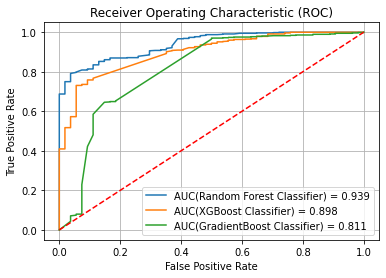

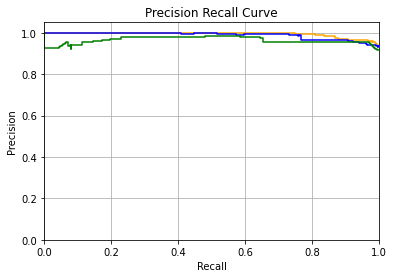

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score,roc_curve,auc

fpr1, tpr1, _ = roc_curve(y_test, prob_1)
fpr2, tpr2, _ = roc_curve(y_test, prob_2)
fpr3, tpr3, _ = roc_curve(y_test, prob_3)

#Receiver Operating Curve(ROC)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr1, tpr1, label = 'AUC(Random Forest Classifier) = %0.3f' % auc(fpr1, tpr1))
plt.plot(fpr2, tpr2, label = 'AUC(XGBoost Classifier) = %0.3f' % auc(fpr2, tpr2))
plt.plot(fpr3, tpr3, label = 'AUC(GradientBoost Classifier) = %0.3f' % auc(fpr3, tpr3))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(True)
plt.show()

#Precision Recall Curve
from sklearn.metrics import precision_recall_curve
precision1, recall1, _ = precision_recall_curve(y_test, prob_1)
precision2, recall2, _ = precision_recall_curve(y_test, prob_2)
precision3, recall3, _ = precision_recall_curve(y_test, prob_3)

plt.step(recall1, precision1, color='orange', where='post')
plt.step(recall2, precision2, color='blue', where='post')
plt.step(recall3, precision3, color='green', where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve')
plt.grid(True)

plt.show()